**Physics Detector Overview**
- We measure energy deposits in a cylindrical detector and see how focused it is in the space of the detector
- Collide particles in the center, stuff comes out and hits the cylinder, then you flatten it and sum the energy

![Introduction](Intro.jpeg)


"uproot (originally μproot, for "micro-Python ROOT") is a reader and a writer of the ROOT file format using only Python and Numpy. 
- Unlike the standard C++ ROOT implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in Python. 
- It uses Numpy to cast blocks of data from the ROOT file as Numpy arrays. ..."

https://github.com/scikit-hep/uproot#introduction

In [8]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

**TTrees?**
- TTrees are special objects in ROOT files: 
- They contain most of the physics data. 

In [9]:
#We care about the EventTree which has been prepared using a full C++ based "Ntuplizer"
#https://github.com/uhussain/ggAnalysis/blob/master/ggNtuplizer/plugins/ggNtuplizer_jets.cc#L177

#Complex set of C++ code, basically gets our physics data in a suitable format for analysis!

In [41]:
#Physics Data array from Simulations (Data)!
def physicsDataArray(FilePrefix,IDs,EventTree,feature):
    #signal = uproot.lazyarray( ["MonoZprime_Mx10_Mv1000-%s.root" % x
    #        for x in ["0030","0040","0050","0060","0070","0080","0090"]],
        # TTree name in each file
    #    "ggNtuplizer/EventTree;1",
        # branch(s) in each file for lazyarray(s)
     #   "jetetaWidth")
    physicsData = uproot.lazyarray([FilePrefix % x for x in IDs],EventTree,feature)
    return physicsData

In [42]:
#Sample Signal
signalFiles= ["0030","0040","0050","0060","0070","0080","0090"]
signal = physicsDataArray("MonoZprime_Mx10_Mv1000-%s.root",signalFiles,"ggNtuplizer/EventTree;1","jetetaWidth")
print(len(signal))
print(type(signal))

3500
<class 'awkward.array.chunked.ChunkedArray'>


In physics data, very common to have an arbitrary number of values per event than a fixed number of values per event. For instance,
- Some events will not have a "good quality" Jet 

Unlike fixed-width arrays and a fixed number of fields per element, Numpy has no analogue for this type. For this, uproot fills a new JaggedArray data structure (from the awkward-array library, like ChunkedArray and VirtualArray)

In [43]:
#Signal events with a jet candidate with momentum (pt > 20 GeV)
#https://github.com/uhussain/ggAnalysis/blob/master/ggNtuplizer/plugins/ggNtuplizer_jets.cc#L556
GoodSignal = np.array(signal[signal.counts>1,0])
len(GoodSignal)

2643

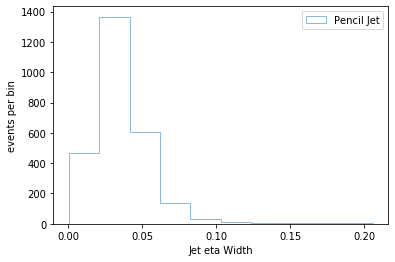

In [44]:
#Plotting this "FEATURE" just for the good signal events
plt.xlabel("Jet eta Width");
plt.ylabel("events per bin");
plt.hist(GoodSignal,histtype='step',alpha=0.5,label='Pencil Jet')
plt.legend()
np.warnings.filterwarnings('ignore')

In [48]:
bkgFiles=["1","2"]
filePrefix="BackgroundZJets/ggtree_mc_%s.root"
treeName="ggNtuplizer/EventTree;25"
Feature="jetetaWidth"

#Physics Data array of some background files!
background = physicsDataArray(filePrefix,bkgFiles,treeName,Feature)

len(background)

199204

In [49]:
#Background events with a jet candidate with momentum (pt > 20 GeV)
GoodBkg = np.array(background[background.counts>1,0])
len(GoodBkg)

198082

In [50]:
#signal and background events normalized to respective "cross-sections" (likelihood of the process) with
sig_w = (1/3500)*(35900*0.10160E+01)
bkg_w = (1/199204)*(35900*10.71)
print("SigNormalizationFactor: ",sig_w)
print("BkgNormalizationFactor: ", bkg_w)
def ApplyWeights(signal,background):
    SigWeights = signal*sig_w
    BkgWeights = background*bkg_w
    return SigWeights,BkgWeights

def PlotHists(sig,sigW,bkg,bkgW,cut):
    plt.xlabel("Jet eta Width");
    plt.ylabel("events per bin");
    plt.hist(sig,histtype='step',weights=sigW,alpha=0.5,log=True,label='Pencil Jet')
    plt.hist(bkg,weights=bkgW,alpha=0.5,log=True,label='Z(vv)+Jets')
    plt.legend()
    if cut==True:
        plt.axvline(0.04)

SigNormalizationFactor:  10.421257142857144
BkgNormalizationFactor:  1.9301269050822276


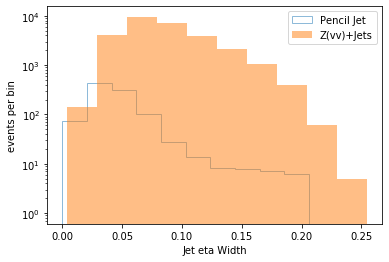

In [51]:
#Plotting signal and background events normalized to respective "cross-sections" (likelihood of the process) 
SigW,BkgW = ApplyWeights(GoodSignal,GoodBkg)
PlotHists(GoodSignal,SigW,GoodBkg,BkgW,False)

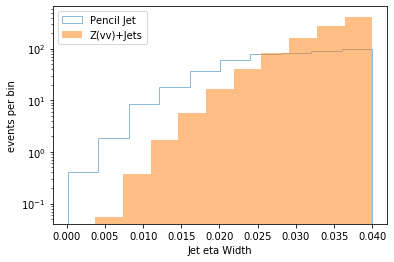

In [52]:
#We can do a basic Cut and Count analysis by cutting on jet eta Width < 0.04 to discriminate signal from background
SelectedSig = GoodSignal[GoodSignal<=0.04]
SelectedBkg = GoodBkg[GoodBkg<=0.04]
#Applying Weights and plotting the two hists
SigW,BkgW = ApplyWeights(SelectedSig,SelectedBkg)
PlotHists(SelectedSig,SigW,SelectedBkg,BkgW,False)

**Why not go harder with the cut at 0.03 or even 0.02 as it seemingly improves "Quality" of the signal vs noise?**
- I want to discover it if it's there, and not discover it if it's not there
- While we want to reduce the "noise" we also want to **preserve the signal efficiency**, which basically refers to the effectiveness in finding such a rare signal from analyzing petabytes of physics data
- I apply **domain knowledge** to identify that a **signal efficiency** below 50% is not acceptable

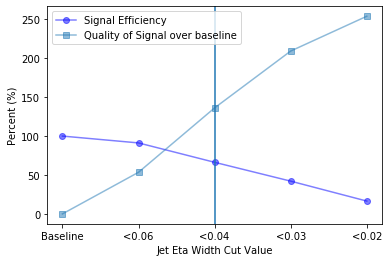

In [38]:
CutValue = ["Baseline","<0.06","<0.04","<0.03","<0.02"]
Quality = [44.5,68.3,105.1,137.6,157.5]
Quality_baseline = []
for i in range(len(Quality)):
    Quality_baseline.append(((Quality[i]-Quality[0])/Quality[0])*100)
Sig_Eff = [100,91.2,66.3,42.1,16.5]
plt.xlabel("Jet Eta Width Cut Value");
plt.ylabel("Percent (%)");
plt.plot(CutValue, Sig_Eff,alpha=0.5,label='Signal Efficiency',marker='o', color='b')
plt.plot(CutValue, Quality_baseline,alpha=0.5,label='Quality of Signal over baseline',marker='s')
plt.legend()
plt.axvline("<0.04")

**Conclusion**

- Model/Classifier built on simulated samples, in physics we can have very accurate simulations of real data.
- Apply this model to real physics data

**BackUp Material/Calculations and plot info shown in table form below this cell** 

In [15]:
Quality_before = (len(GoodSignal)*sig_w)/(np.sqrt(len(GoodBkg)*bkg_w))

In [16]:
Quality_After = (len(SelectedSig)*sig_w)/(np.sqrt(len(SelectedBkg)*bkg_w))

In [17]:
SigEff_base = len(GoodSignal)/2643.0
SigEff = len(SelectedSig)/2643.0
print("TotalBkg: ",(len(GoodBkg)))
print ("S/sqrt(B) Before: ",Quality_before)
print ("SigEfficiency (before): ", "%.2f" %(SigEff_base*100),"%")
print ("S/sqrt(B) After: ",Quality_After)
print ("SigEfficiency (after): ", "%.2f" %(SigEff*100),"%")

TotalBkg:  198082
S/sqrt(B) Before:  44.545294735908264
SigEfficiency (before):  100.00 %
S/sqrt(B) After:  105.11241359854189
SigEfficiency (after):  66.29 %


|sig_w=10.42, bkg_w=1.93|Baseline | JetEtaWidth < 0.06| **JetEtaWidth < 0.04** |JetEtaWidth < 0.03 |JetEtaWidth < 0.02|
| ------------------- |         |                   |                       |                  |                  |
| Total Signal (S)    |2643     |2410               |1752                   |1113              |435               |
| Total Background (B)|198082   |70039              |15632                  |3679              |429             |
| Signal Eff.         |100%     |91.18 %            |66.29%                 |42.11 %           |16.46 %           |
| (S * sig_w)/sqrt(B * bkg_w)         |44.5     |68.3               |105.1                  |137.6             |157.5             |